# Tweet Virality Analysis: Time Interval Impact

This notebook analyzes the relationship between time intervals and tweet virality.

In [11]:
import numpy as np
import pandas as pd
import datasets
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Load Dataset and Add Viral Column

In [13]:
# Load the dataset
raw_dataset = datasets.load_from_disk("/home/jqcao/projects/retweet-prediction/data/raw_dataset")

# Define function to add viral column
def add_viral_column(example):
    """Add if_viral column based on retweet_count"""
    example['if_viral'] = example['retweet_count'] >= 10
    return example

# Apply to train and eval splits only
if 'train' in raw_dataset:
    raw_dataset['train'] = raw_dataset['train'].map(
        add_viral_column,
        batched=False,
        num_proc=64,
        load_from_cache_file=False,
    )
    
if 'eval' in raw_dataset:
    raw_dataset['eval'] = raw_dataset['eval'].map(
        add_viral_column,
        batched=False,
        num_proc=64,
        load_from_cache_file=False,
    )

print(f"Dataset splits: {list(raw_dataset.keys())}")
print(f"Train dataset size: {len(raw_dataset['train'])}")
print(f"Eval dataset size: {len(raw_dataset['eval'])}")

Map (num_proc=64): 100%|██████████| 3000/3000 [00:00<00:00, 8278.97 examples/s]


Dataset splits: ['train', 'test', 'eval']
Train dataset size: 662777
Eval dataset size: 3000


## 2. Convert Dataset to DataFrame for Analysis

In [14]:
# Convert datasets to pandas DataFrames for easier analysis
train_df = raw_dataset['train'].to_pandas()
eval_df = raw_dataset['eval'].to_pandas()

# Combine for time analysis
df = pd.concat([train_df, eval_df], ignore_index=True)

# Convert timestamp from milliseconds to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

print(f"Combined dataset size: {len(df)}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nViral tweets: {df['if_viral'].sum()} ({df['if_viral'].mean()*100:.2f}%)")

Combined dataset size: 665777

Dataset columns: ['id', 'timestamp', 'retweet_count', 'user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'user_mentions', 'urls', 'hashtags', 'text', 'if_viral', 'datetime']

Viral tweets: 100428 (15.08%)


## 3. Time Interval Analysis (20 Equal Intervals)

In [15]:
# Find earliest and latest tweets
earliest_time = df['datetime'].min()
latest_time = df['datetime'].max()

print(f"Earliest tweet: {earliest_time}")
print(f"Latest tweet: {latest_time}")
print(f"Time span: {latest_time - earliest_time}")

# Create 20 equal time intervals
df['time_interval'] = pd.cut(df['datetime'], bins=20, labels=range(1, 21))

# Calculate viral rate for each interval
interval_analysis = df.groupby('time_interval').agg({
    'if_viral': ['sum', 'count', 'mean']
}).round(4)

interval_analysis.columns = ['viral_count', 'total_tweets', 'viral_rate']
interval_analysis['viral_percentage'] = interval_analysis['viral_rate'] * 100

print("\nViral rate by time interval:")
print(interval_analysis)

Earliest tweet: 2020-04-30 21:59:36.689000
Latest tweet: 2020-05-05 21:59:39.848000
Time span: 5 days 00:00:03.159000

Viral rate by time interval:
               viral_count  total_tweets  viral_rate  viral_percentage
time_interval                                                         
1                    12144         59587      0.2038             20.38
2                     8455         38609      0.2190             21.90
3                     7469         44900      0.1663             16.63
4                     6618         48241      0.1372             13.72
5                      339         21992      0.0154              1.54
6                      230         13602      0.0169              1.69
7                      293         19133      0.0153              1.53
8                      131         22662      0.0058              0.58
9                     4746         28235      0.1681             16.81
10                    4424         20459      0.2162             21.62


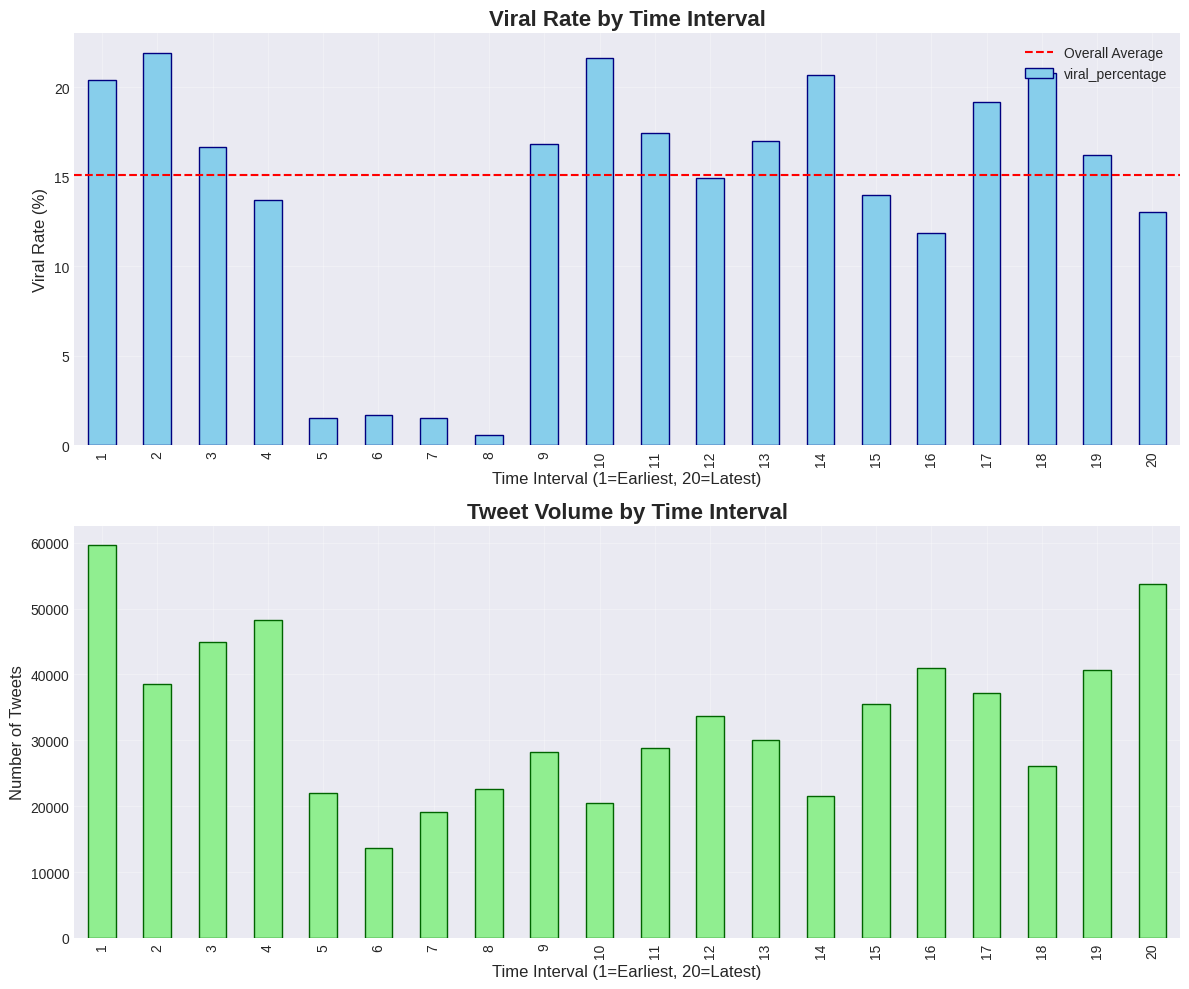

In [16]:
# Visualize viral rate across time intervals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Viral rate by interval
interval_analysis['viral_percentage'].plot(kind='bar', ax=ax1, color='skyblue', edgecolor='navy')
ax1.set_title('Viral Rate by Time Interval', fontsize=16, fontweight='bold')
ax1.set_xlabel('Time Interval (1=Earliest, 20=Latest)', fontsize=12)
ax1.set_ylabel('Viral Rate (%)', fontsize=12)
ax1.axhline(y=df['if_viral'].mean()*100, color='red', linestyle='--', label='Overall Average')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Tweet volume by interval
interval_analysis['total_tweets'].plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='darkgreen')
ax2.set_title('Tweet Volume by Time Interval', fontsize=16, fontweight='bold')
ax2.set_xlabel('Time Interval (1=Earliest, 20=Latest)', fontsize=12)
ax2.set_ylabel('Number of Tweets', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Hour of Day Analysis

In [17]:
# Extract hour from datetime
df['hour'] = df['datetime'].dt.hour

# Calculate viral rate by hour of day
hour_analysis = df.groupby('hour').agg({
    'if_viral': ['sum', 'count', 'mean']
}).round(4)

hour_analysis.columns = ['viral_count', 'total_tweets', 'viral_rate']
hour_analysis['viral_percentage'] = hour_analysis['viral_rate'] * 100

print("Viral rate by hour of day:")
print(hour_analysis)

Viral rate by hour of day:
      viral_count  total_tweets  viral_rate  viral_percentage
hour                                                         
0            4631         28278      0.1638             16.38
1            4590         26902      0.1706             17.06
2            4224         24758      0.1706             17.06
3            4093         23054      0.1775             17.75
4            3924         20835      0.1883             18.83
5            3822         19413      0.1969             19.69
6            3724         19139      0.1946             19.46
7            3837         19757      0.1942             19.42
8            3965         20728      0.1913             19.13
9            3697         20420      0.1810             18.10
10           3661         21878      0.1673             16.73
11           4059         25005      0.1623             16.23
12           4073         27433      0.1485             14.85
13           4274         30439      0.1404

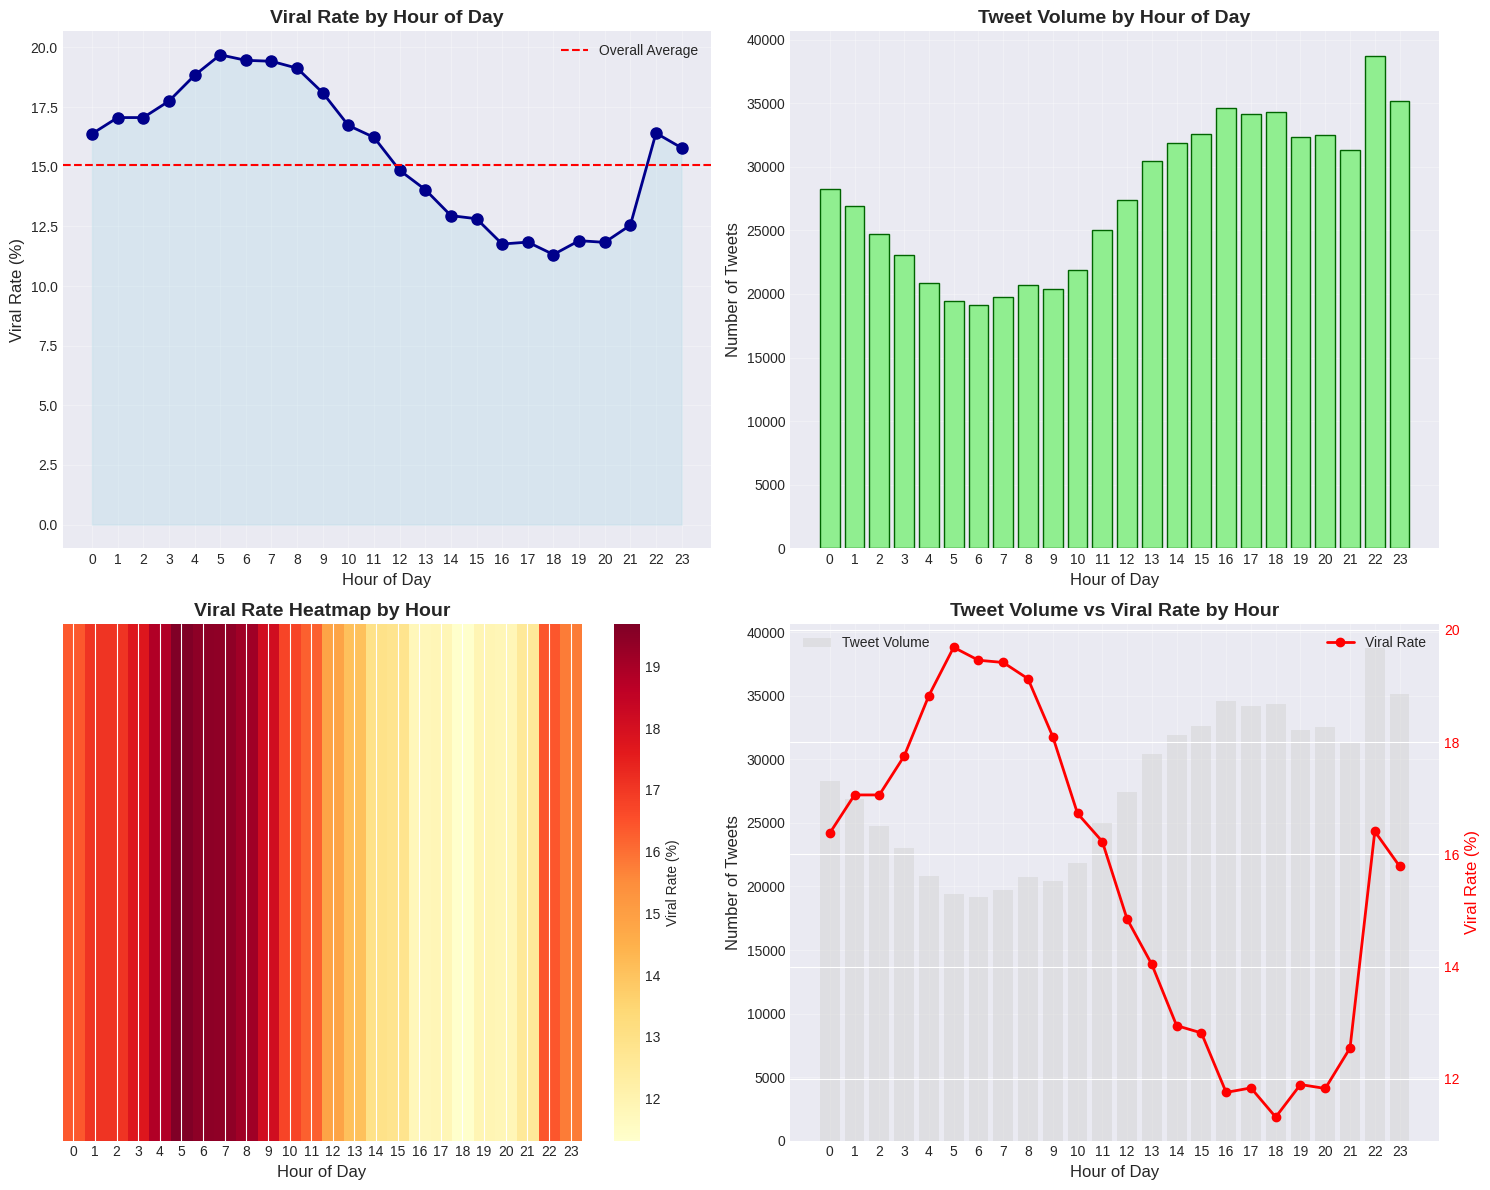

In [18]:
# Visualize hour of day impact
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Viral rate by hour (line plot)
axes[0, 0].plot(hour_analysis.index, hour_analysis['viral_percentage'], 
                marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0, 0].fill_between(hour_analysis.index, hour_analysis['viral_percentage'], 
                        alpha=0.3, color='lightblue')
axes[0, 0].set_title('Viral Rate by Hour of Day', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
axes[0, 0].set_ylabel('Viral Rate (%)', fontsize=12)
axes[0, 0].set_xticks(range(0, 24))
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=df['if_viral'].mean()*100, color='red', linestyle='--', label='Overall Average')
axes[0, 0].legend()

# Plot 2: Tweet volume by hour
axes[0, 1].bar(hour_analysis.index, hour_analysis['total_tweets'], 
               color='lightgreen', edgecolor='darkgreen')
axes[0, 1].set_title('Tweet Volume by Hour of Day', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day', fontsize=12)
axes[0, 1].set_ylabel('Number of Tweets', fontsize=12)
axes[0, 1].set_xticks(range(0, 24))
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Heatmap of viral rate by hour
hour_matrix = hour_analysis['viral_percentage'].values.reshape(1, -1)
im = axes[1, 0].imshow(hour_matrix, aspect='auto', cmap='YlOrRd')
axes[1, 0].set_title('Viral Rate Heatmap by Hour', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day', fontsize=12)
axes[1, 0].set_yticks([])
axes[1, 0].set_xticks(range(0, 24))
plt.colorbar(im, ax=axes[1, 0], label='Viral Rate (%)')

# Plot 4: Combined visualization
ax2 = axes[1, 1].twinx()
axes[1, 1].bar(hour_analysis.index, hour_analysis['total_tweets'], 
               alpha=0.5, color='lightgray', label='Tweet Volume')
ax2.plot(hour_analysis.index, hour_analysis['viral_percentage'], 
         'ro-', linewidth=2, markersize=6, label='Viral Rate')
axes[1, 1].set_title('Tweet Volume vs Viral Rate by Hour', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day', fontsize=12)
axes[1, 1].set_ylabel('Number of Tweets', fontsize=12)
ax2.set_ylabel('Viral Rate (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
axes[1, 1].set_xticks(range(0, 24))
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Statistical Analysis

In [19]:
# Find peak and low viral rate hours
peak_hour = hour_analysis['viral_percentage'].idxmax()
low_hour = hour_analysis['viral_percentage'].idxmin()
peak_rate = hour_analysis.loc[peak_hour, 'viral_percentage']
low_rate = hour_analysis.loc[low_hour, 'viral_percentage']

print(f"Peak viral hour: {peak_hour}:00 (Viral rate: {peak_rate:.2f}%)")
print(f"Lowest viral hour: {low_hour}:00 (Viral rate: {low_rate:.2f}%)")
print(f"Difference: {peak_rate - low_rate:.2f} percentage points")
print(f"Relative increase: {(peak_rate/low_rate - 1)*100:.1f}%")

# Time interval statistics
print("\n" + "="*50)
print("Time Interval Statistics:")
print(f"Highest viral rate interval: Interval {interval_analysis['viral_percentage'].idxmax()} "
      f"({interval_analysis['viral_percentage'].max():.2f}%)")
print(f"Lowest viral rate interval: Interval {interval_analysis['viral_percentage'].idxmin()} "
      f"({interval_analysis['viral_percentage'].min():.2f}%)")
print(f"Standard deviation of viral rates: {interval_analysis['viral_percentage'].std():.2f}%")

Peak viral hour: 5:00 (Viral rate: 19.69%)
Lowest viral hour: 18:00 (Viral rate: 11.32%)
Difference: 8.37 percentage points
Relative increase: 73.9%

Time Interval Statistics:
Highest viral rate interval: Interval 2 (21.90%)
Lowest viral rate interval: Interval 8 (0.58%)
Standard deviation of viral rates: 7.14%


## 6. Time Period Categorization

In [20]:
# Categorize hours into time periods
def categorize_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning (6-12)'
    elif 12 <= hour < 18:
        return 'Afternoon (12-18)'
    elif 18 <= hour < 24:
        return 'Evening (18-24)'
    else:
        return 'Night (0-6)'

df['time_period'] = df['hour'].apply(categorize_time_period)

# Analyze by time period
period_analysis = df.groupby('time_period').agg({
    'if_viral': ['sum', 'count', 'mean']
}).round(4)

period_analysis.columns = ['viral_count', 'total_tweets', 'viral_rate']
period_analysis['viral_percentage'] = period_analysis['viral_rate'] * 100

# Sort by custom order
period_order = ['Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)', 'Night (0-6)']
period_analysis = period_analysis.reindex(period_order)

print("Viral rate by time period:")
print(period_analysis)

Viral rate by time period:
                   viral_count  total_tweets  viral_rate  viral_percentage
time_period                                                               
Morning (6-12)           22943        126927      0.1808             18.08
Afternoon (12-18)        24783        191218      0.1296             12.96
Evening (18-24)          27418        204392      0.1341             13.41
Night (0-6)              25284        143240      0.1765             17.65


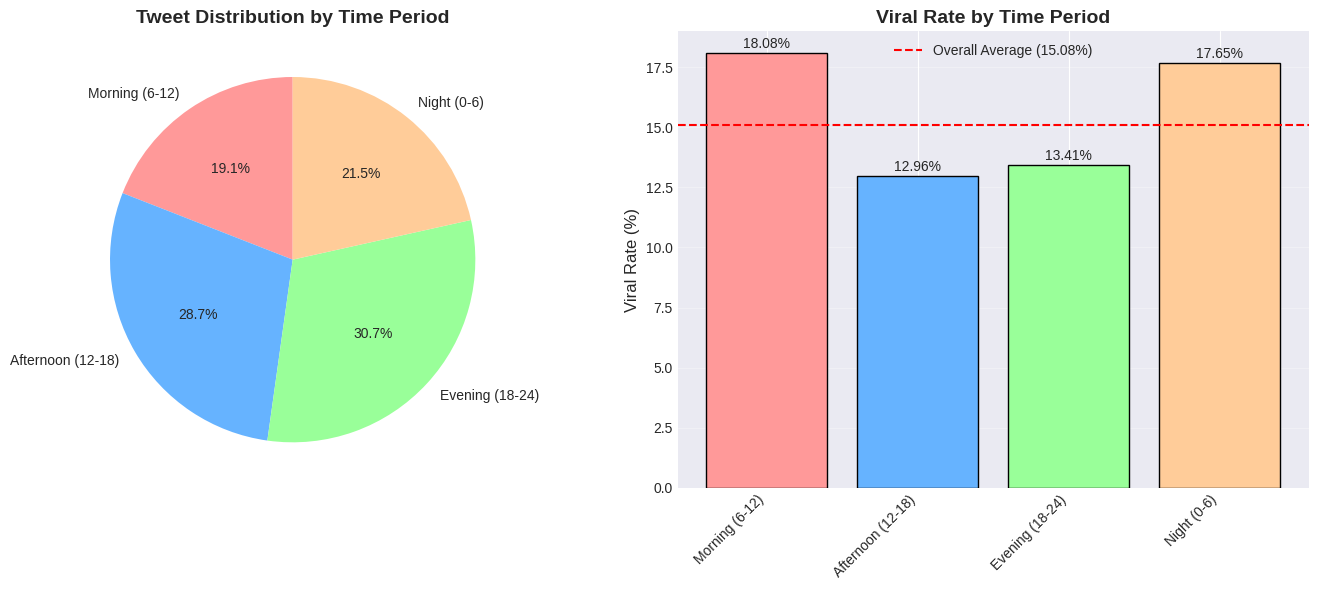

In [21]:
# Visualize time period analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart of tweet distribution
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
ax1.pie(period_analysis['total_tweets'], labels=period_analysis.index, 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Tweet Distribution by Time Period', fontsize=14, fontweight='bold')

# Bar chart of viral rates
bars = ax2.bar(range(len(period_analysis)), period_analysis['viral_percentage'], 
                color=colors, edgecolor='black')
ax2.set_xticks(range(len(period_analysis)))
ax2.set_xticklabels(period_analysis.index, rotation=45, ha='right')
ax2.set_title('Viral Rate by Time Period', fontsize=14, fontweight='bold')
ax2.set_ylabel('Viral Rate (%)', fontsize=12)
ax2.axhline(y=df['if_viral'].mean()*100, color='red', linestyle='--', 
            label=f'Overall Average ({df["if_viral"].mean()*100:.2f}%)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 7. Summary and Insights

In [22]:
print("=" * 60)
print("SUMMARY OF FINDINGS")
print("=" * 60)

print("\n1. OVERALL STATISTICS:")
print(f"   - Total tweets analyzed: {len(df):,}")
print(f"   - Overall viral rate: {df['if_viral'].mean()*100:.2f}%")
print(f"   - Total viral tweets: {df['if_viral'].sum():,}")

print("\n2. TIME INTERVAL ANALYSIS (20 intervals):")
print(f"   - Most viral interval: Interval {interval_analysis['viral_percentage'].idxmax()} "
      f"({interval_analysis['viral_percentage'].max():.2f}%)")
print(f"   - Least viral interval: Interval {interval_analysis['viral_percentage'].idxmin()} "
      f"({interval_analysis['viral_percentage'].min():.2f}%)")
print(f"   - Variation (std dev): {interval_analysis['viral_percentage'].std():.2f}%")

print("\n3. HOUR OF DAY ANALYSIS:")
print(f"   - Best hour for virality: {peak_hour}:00 ({peak_rate:.2f}%)")
print(f"   - Worst hour for virality: {low_hour}:00 ({low_rate:.2f}%)")
print(f"   - Peak vs Low difference: {(peak_rate/low_rate - 1)*100:.1f}% increase")

print("\n4. TIME PERIOD ANALYSIS:")
best_period = period_analysis['viral_percentage'].idxmax()
worst_period = period_analysis['viral_percentage'].idxmin()
print(f"   - Best time period: {best_period} ({period_analysis.loc[best_period, 'viral_percentage']:.2f}%)")
print(f"   - Worst time period: {worst_period} ({period_analysis.loc[worst_period, 'viral_percentage']:.2f}%)")

print("\n" + "=" * 60)

SUMMARY OF FINDINGS

1. OVERALL STATISTICS:
   - Total tweets analyzed: 665,777
   - Overall viral rate: 15.08%
   - Total viral tweets: 100,428

2. TIME INTERVAL ANALYSIS (20 intervals):
   - Most viral interval: Interval 2 (21.90%)
   - Least viral interval: Interval 8 (0.58%)
   - Variation (std dev): 7.14%

3. HOUR OF DAY ANALYSIS:
   - Best hour for virality: 5:00 (19.69%)
   - Worst hour for virality: 18:00 (11.32%)
   - Peak vs Low difference: 73.9% increase

4. TIME PERIOD ANALYSIS:
   - Best time period: Morning (6-12) (18.08%)
   - Worst time period: Afternoon (12-18) (12.96%)

